In [5]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import imagehash
import random
import sys

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        raise ValueError("Invalid base64 string format")
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    if "canvases" not in data or not isinstance(data["canvases"], list):
        raise ValueError("Invalid data format: 'canvases' key is missing or not a list")
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername aus den Argumenten abrufen
username1 = "username_2"
username2 = "username_5"

# Positive Beispiele (Canvases des aktuellen Benutzers)
user1 = collection.find_one({"username": username1})
user2 = collection.find_one({"username": username2})

if user1 is None or user2 is None:
    print(f"One or both users not found: {username1}, {username2}")
    sys.exit(1)

# Abrufen der Canvases
user1_canvases = get_canvases(user1)
user2_canvases = get_canvases(user2)

# Zufällige Auswahl eines Canvas von jedem Benutzer für den Vergleich
image1 = random.choice(user1_canvases)
image2 = random.choice(user2_canvases)

# Generieren der Hashes
hash1 = imagehash.phash(image1)
hash2 = imagehash.phash(image2)

# Vergleichen der Hashes
hash_difference = hash1 - hash2

print(f"Hash for {username1}: {hash1}")
print(f"Hash for {username2}: {hash2}")
print(f"Hash difference: {hash_difference}")

# Bestimmen der Ähnlichkeit
if hash_difference == 0:
    print("The images are identical.")
else:
    print(f"The images are different with a hash difference of {hash_difference}.")


Hash for username_2: e3181c1c1e0f0ff7
Hash for username_5: e31818181c1f3eff
Hash difference: 8
The images are different with a hash difference of 8.


In [6]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GPU-Speicherwachstum aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        raise ValueError("Invalid base64 string format")
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    if "canvases" not in data or not isinstance(data["canvases"], list):
        raise ValueError("Invalid data format: 'canvases' key is missing or not a list")
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername aus den Argumenten abrufen
username = "username_2"

# Modellpfad anpassen je nach dem wo das Skript ausgeführt wird
if 'src' in os.getcwd():
    model_path = f'src/SWAT_auth/models/{username}_fingerprint_model.h5'
else:
    model_path = f'SWAT_auth/models/{username}_fingerprint_model.h5'

# Überprüfen, ob das Modell bereits existiert
if os.path.exists(model_path):
    print(f"Model for {username} already exists at {model_path}")
    sys.exit(0)

print(f"Creating model for {username}")

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
if user is None:
    print(f"No user found with username {username}")
    sys.exit(1)

user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

for other_user in collection.find({"username": {"$ne": username}}):
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Data preparation complete.")


Creating model for username_2


KeyboardInterrupt: 

In [ ]:
# Modell 1 definieren
def create_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 2 definieren
def create_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 3 definieren
def create_model_3(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 4 definieren (z.B. VGG-ähnliche Architektur)
def create_model_4(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 5 definieren (z.B. ResNet-ähnliche Architektur)
def create_model_5(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 6 definieren (z.B. Inception-ähnliche Architektur)
def create_model_6(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape = X_train.shape[1:]
models = [
    create_model_1(input_shape),
    create_model_2(input_shape),
    create_model_3(input_shape),
    create_model_4(input_shape),
    create_model_5(input_shape),
    create_model_6(input_shape)
]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_accuracy = 0
best_model = None

# Modelle nacheinander trainieren und bewerten
results = []
for i, (model, name) in enumerate(zip(models, model_names), start=1):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Speichern des Modells mit einem spezifischen Namen
    model_checkpoint = ModelCheckpoint(f'models/{username}_{i}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])
    
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")
    results.append({'Model': name, 'Accuracy': accuracy})

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Bestes Modell speichern
if best_model is not None:
    best_model.save(f'models/{username}_best.h5')
    print(f"Best model saved at src/SWAT_auth/models/{username}_best.h5 with accuracy {best_accuracy}")
else:
    print("No model was trained successfully.")

Epoch 1/50
440/440 [==============================] - 8s 9ms/step - loss: 0.7723 - accuracy: 0.5844 - val_loss: 0.5645 - val_accuracy: 0.6125
Epoch 2/50
440/440 [==============================] - 4s 8ms/step - loss: 0.5131 - accuracy: 0.6952 - val_loss: 0.5916 - val_accuracy: 0.6193
Epoch 3/50
121/440 [=======>......................] - ETA: 2s - loss: 0.4892 - accuracy: 0.7200

KeyboardInterrupt: 

In [ ]:
  # Ergebnisse in einem DataFrame anzeigen
results_df = pd.DataFrame(results)
print(results_df)

# Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Modellvergleich')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.show()


In [ ]:
import visualkeras

#for model, name in zip(models, model_names):
    # Modellarchitektur visualisieren
#    visualkeras.layered_view(model, to_file=f'{name}_architecture.png').show()


28/28 [==============================] - 1s 8ms/step - loss: 0.5099 - accuracy: 0.7057
Model 1 - Test Loss: 0.5099363327026367
Model 1 - Test Accuracy: 0.7056818008422852
28/28 [==============================] - 0s 4ms/step


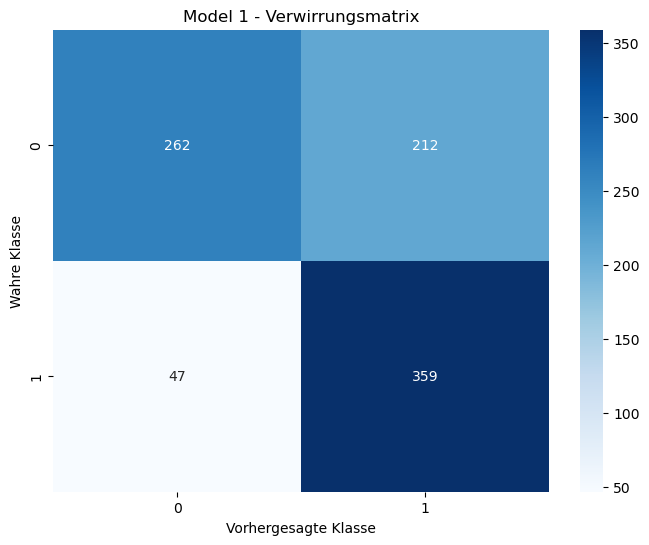

Model 1 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.85      0.55      0.67       474
         1.0       0.63      0.88      0.73       406

    accuracy                           0.71       880
   macro avg       0.74      0.72      0.70       880
weighted avg       0.75      0.71      0.70       880



RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

for model, name in zip(models, model_names):
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")

    # Vorhersagen auf dem Testdatensatz
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Verwirrungsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Verwirrungsmatrix')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.show()

    # Klassifikationsbericht anzeigen
    print(f"{name} - Klassifikationsbericht")
    print(classification_report(y_test, y_pred_classes))



Testing models with prefix: username_4
Loaded models: []
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4


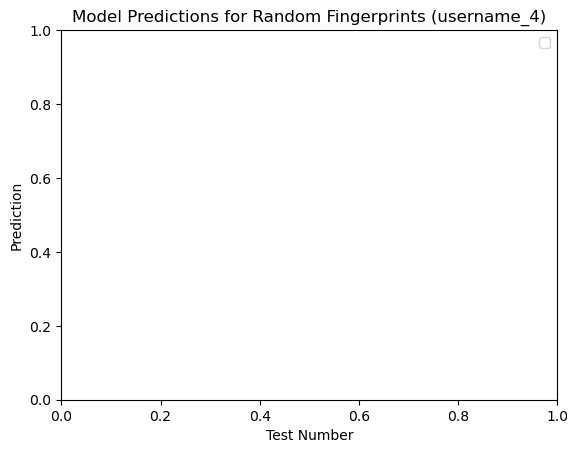


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5']
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
1/1 [==============================] - 0s 101ms/step


ValueError: in user code:

    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 75, 75, 3), found shape=(None, 35, 280, 4)


In [8]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints(prefixes, num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: {username: [] for username in prefixes} for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name][username].append(prediction[0][0])
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for username in prefixes:
            print(f"Against fingerprints of {username}:")
            for i, result in enumerate(all_results[name][username]):
                print(f"Test {i+1}: Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        for username in prefixes:
            if len(all_results[name][username]) == num_tests:
                ax.plot(range(num_tests), all_results[name][username], label=f"{name} vs {username}")
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, (username, image) in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(username)
    axes[i].axis('off')
plt.show()

In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append(image)
    return images

# Präfixe für die Modelle
prefixes = ["username_2", "username_5"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints([prefix], num_tests)
    prepared_images = [prepare_image(image, target_size=(280, 35)) for image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append(prediction[0][0])
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, result in enumerate(all_results[name]):
            print(f"Test {i+1}: Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        ax.plot(range(num_tests), all_results[name], label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, image in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
plt.show()


In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints(prefixes, num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append((username, prediction[0][0]))
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, (username, result) in enumerate(all_results[name]):
            print(f"Test {i+1}: Username = {username}, Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        results = [result for username, result in all_results[name]]
        ax.plot(range(num_tests), results, label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, (username, image) in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(username)
    axes[i].axis('off')
plt.show()


In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Testen der Modelle mit Fingerabdrücken des gleichen Präfixes
    print(f"\nTesting models with fingerprints from {prefix}")
    images = get_multiple_fingerprints([prefix], num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append((username, prediction[0][0]))
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, (username, result) in enumerate(all_results[name]):
            print(f"Test {i+1}: Username = {username}, Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        results = [result for username, result in all_results[name]]
        ax.plot(range(num_tests), results, label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Fingerprints from {prefix}')
    ax.legend()
    plt.show()

    # Fingerabdrücke anzeigen
    fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
    for i, (username, image) in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(username)
        axes[i].axis('off')
    plt.show()

    # Testen der Modelle mit Fingerabdrücken von anderen Präfixen
    other_prefixes = [p for p in prefixes if p != prefix]
    for other_prefix in other_prefixes:
        print(f"\nTesting models with fingerprints from {other_prefix}")
        images = get_multiple_fingerprints([other_prefix], num_tests)
        prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
        
        # Ergebnisse speichern
        all_results = {name: [] for name in model_names}
        for username, image_array_normalized in prepared_images:
            for model, name in zip(models, model_names):
                prediction = model.predict(image_array_normalized)
                all_results[name].append((username, prediction[0][0]))
        
        # Ergebnisse in der Konsole ausgeben
        for name in model_names:
            print(f"\nResults for model: {name}")
            for i, (username, result) in enumerate(all_results[name]):
                print(f"Test {i+1}: Username = {username}, Prediction = {result}")
        
        # Ergebnisse grafisch darstellen
        fig, ax = plt.subplots()
        for name in model_names:
            results = [result for username, result in all_results[name]]
            ax.plot(range(num_tests), results, label=name)
        ax.set_xlabel('Test Number')
        ax.set_ylabel('Prediction')
        ax.set_title(f'Model Predictions for Fingerprints from {other_prefix}')
        ax.legend()
        plt.show()

        # Fingerabdrücke anzeigen
        fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
        for i, (username, image) in enumerate(images):
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(username)
            axes[i].axis('off')
        plt.show()
